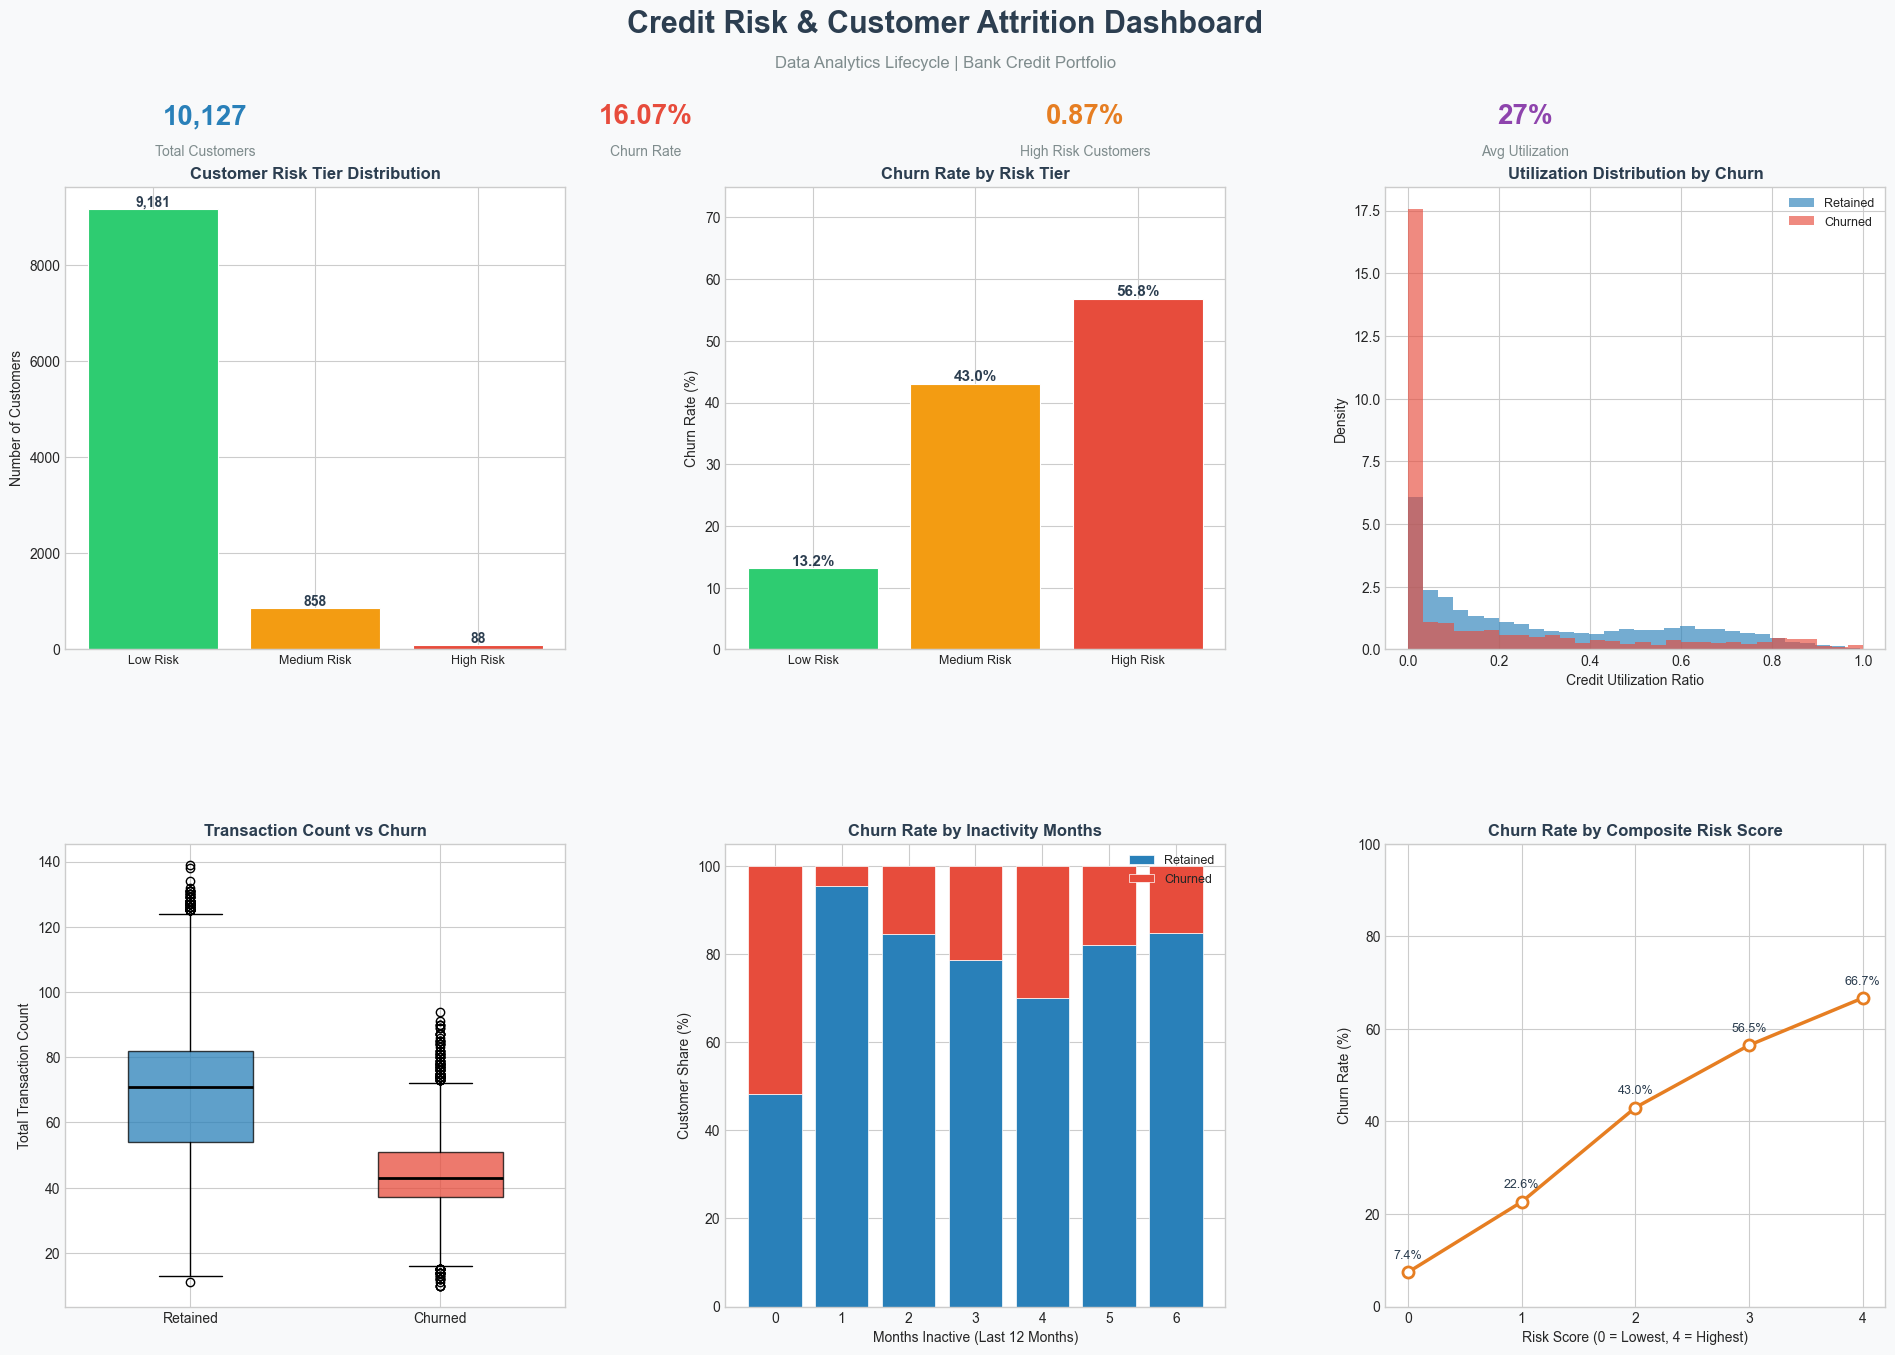

Dashboard saved.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ─── Load Data ────────────────────────────────────────────────────────────────
df = pd.read_csv("../Data/risk_segmented_data.csv")

# ─── KPIs ─────────────────────────────────────────────────────────────────────
total_customers = len(df)
churn_rate      = round(df["Churn_Binary"].mean() * 100, 2)
high_risk_pct   = round((df["Risk_Tier"] == "High Risk").mean() * 100, 2)
avg_util        = round(df["calculated_utilization"].mean(), 2)

# ─── Style ────────────────────────────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
COLORS = {"Low Risk": "#2ecc71", "Medium Risk": "#f39c12", "High Risk": "#e74c3c"}
BLUE   = "#2980b9"

fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor("#f8f9fa")

# ─── Title ────────────────────────────────────────────────────────────────────
fig.text(0.5, 0.97, "Credit Risk & Customer Attrition Dashboard",
         ha="center", fontsize=22, fontweight="bold", color="#2c3e50")
fig.text(0.5, 0.945, "Data Analytics Lifecycle | Bank Credit Portfolio",
         ha="center", fontsize=12, color="#7f8c8d")

# ─── KPI Row ──────────────────────────────────────────────────────────────────
kpi_data = [
    ("Total Customers",     f"{total_customers:,}", "#2980b9"),
    ("Churn Rate",          f"{churn_rate}%",       "#e74c3c"),
    ("High Risk Customers", f"{high_risk_pct}%",    "#e67e22"),
    ("Avg Utilization",     f"{avg_util:.0%}",      "#8e44ad"),
]
for i, (label, value, color) in enumerate(kpi_data):
    x = 0.13 + i * 0.22
    fig.text(x, 0.905, value, ha="center", fontsize=20, fontweight="bold", color=color)
    fig.text(x, 0.882, label, ha="center", fontsize=10, color="#7f8c8d")

# ─── 6-Chart Grid ─────────────────────────────────────────────────────────────
gs = gridspec.GridSpec(2, 3, figure=fig,
                       top=0.86, bottom=0.06,
                       left=0.06, right=0.97,
                       hspace=0.42, wspace=0.32)

tier_order = ["Low Risk", "Medium Risk", "High Risk"]

# Chart 1: Risk Tier Distribution
ax1 = fig.add_subplot(gs[0, 0])
tier_counts = df["Risk_Tier"].value_counts().reindex(tier_order)
bars = ax1.bar(tier_order, tier_counts.values,
               color=[COLORS[t] for t in tier_order], edgecolor="white", linewidth=0.8)
for bar, v in zip(bars, tier_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 60,
             f"{v:,}", ha="center", fontsize=10, fontweight="bold", color="#2c3e50")
ax1.set_title("Customer Risk Tier Distribution", fontweight="bold", color="#2c3e50")
ax1.set_ylabel("Number of Customers")
ax1.tick_params(axis="x", labelsize=9)

# Chart 2: Churn Rate by Risk Tier
ax2 = fig.add_subplot(gs[0, 1])
churn_by_tier = df.groupby("Risk_Tier")["Churn_Binary"].mean().reindex(tier_order) * 100
bars2 = ax2.bar(tier_order, churn_by_tier.values,
                color=[COLORS[t] for t in tier_order], edgecolor="white", linewidth=0.8)
for bar, v in zip(bars2, churn_by_tier.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{v:.1f}%", ha="center", fontsize=11, fontweight="bold", color="#2c3e50")
ax2.set_title("Churn Rate by Risk Tier", fontweight="bold", color="#2c3e50")
ax2.set_ylabel("Churn Rate (%)")
ax2.set_ylim(0, 75)
ax2.tick_params(axis="x", labelsize=9)

# Chart 3: Utilization Distribution by Churn
ax3 = fig.add_subplot(gs[0, 2])
churned     = df[df["Churn_Binary"] == 1]["calculated_utilization"].dropna()
not_churned = df[df["Churn_Binary"] == 0]["calculated_utilization"].dropna()
ax3.hist(not_churned, bins=30, alpha=0.65, color=BLUE,      label="Retained", density=True)
ax3.hist(churned,     bins=30, alpha=0.65, color="#e74c3c", label="Churned",  density=True)
ax3.set_title("Utilization Distribution by Churn", fontweight="bold", color="#2c3e50")
ax3.set_xlabel("Credit Utilization Ratio")
ax3.set_ylabel("Density")
ax3.legend(fontsize=9)

# Chart 4: Transaction Count vs Churn (box plot)
ax4 = fig.add_subplot(gs[1, 0])
df["Churn_Label"] = df["Churn_Binary"].map({0: "Retained", 1: "Churned"})
data_retained = df[df["Churn_Label"] == "Retained"]["Total_Trans_Ct"]
data_churned  = df[df["Churn_Label"] == "Churned"]["Total_Trans_Ct"]
bp = ax4.boxplot([data_retained, data_churned], tick_labels=["Retained", "Churned"],
                 patch_artist=True, widths=0.5,
                 medianprops=dict(color="black", linewidth=2))
bp["boxes"][0].set_facecolor(BLUE)
bp["boxes"][1].set_facecolor("#e74c3c")
for box in bp["boxes"]: box.set_alpha(0.75)
ax4.set_title("Transaction Count vs Churn", fontweight="bold", color="#2c3e50")
ax4.set_ylabel("Total Transaction Count")

# Chart 5: Churn Rate by Inactivity Months (stacked bar)
ax5 = fig.add_subplot(gs[1, 1])
inact = (df.groupby(["Months_Inactive_12_mon", "Churn_Label"])
           .size().unstack(fill_value=0))
inact_pct = inact.div(inact.sum(axis=1), axis=0) * 100
bottom_vals = np.zeros(len(inact_pct))
for col, color in [("Retained", BLUE), ("Churned", "#e74c3c")]:
    if col in inact_pct.columns:
        ax5.bar(inact_pct.index, inact_pct[col], bottom=bottom_vals,
                color=color, label=col, edgecolor="white", linewidth=0.5)
        bottom_vals += inact_pct[col].values
ax5.set_title("Churn Rate by Inactivity Months", fontweight="bold", color="#2c3e50")
ax5.set_xlabel("Months Inactive (Last 12 Months)")
ax5.set_ylabel("Customer Share (%)")
ax5.legend(fontsize=9)

# Chart 6: Risk Score vs Churn Rate (line chart)
ax6 = fig.add_subplot(gs[1, 2])
churn_by_score = (df.groupby("Risk_Score")["Churn_Binary"].mean() * 100).reset_index()
ax6.plot(churn_by_score["Risk_Score"], churn_by_score["Churn_Binary"],
         marker="o", linewidth=2.5, markersize=8,
         color="#e67e22", markerfacecolor="white", markeredgewidth=2)
for _, row in churn_by_score.iterrows():
    ax6.annotate(f"{row['Churn_Binary']:.1f}%",
                 (row["Risk_Score"], row["Churn_Binary"]),
                 textcoords="offset points", xytext=(0, 10),
                 ha="center", fontsize=9, color="#2c3e50")
ax6.set_title("Churn Rate by Composite Risk Score", fontweight="bold", color="#2c3e50")
ax6.set_xlabel("Risk Score (0 = Lowest, 4 = Highest)")
ax6.set_ylabel("Churn Rate (%)")
ax6.set_xticks([0, 1, 2, 3, 4])
ax6.set_ylim(0, 100)

# ─── Save ─────────────────────────────────────────────────────────────────────
plt.savefig("professional_credit_dashboard.png", dpi=150,
            bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()
print("Dashboard saved.")